<a href="https://colab.research.google.com/github/aperdomoll90/city-cares-api/blob/main/CITY_Cares_WASTE_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CITY CARES 

In [27]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


unzip images

In [28]:
import os
import zipfile as zf

BASE_DIR = "/content/gdrive/MyDrive/Colab Notebooks"
# os.listdir(BASE_DIR)
os.chdir(BASE_DIR)


files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()


os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash', '.DS_Store']

In [32]:
import random 
import shutil

## splits indices for a folder into train, validation, and test indices with random sampling
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [35]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [38]:
from pathlib import Path


import torch
import fastai
from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.metrics import error_rate, accuracy


import warnings
warnings.filterwarnings('ignore')

from os import listdir
!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


# BASE_DIR = "/content/gdrive/MyDrive/Colab Notebooks"

# DATASET_DIR = os.path.join(BASE_DIR,"data")
# !ls $DATASET_DIR



# BASE_DIR = "/Users/mika/Projects/fastai-waste-classifier/data"
# TEST_PHOTOS_DIR = f"{DATASET_DIR}/test"
# !ls $DATASET_DIR
# test  train

# data = ImageDataLoaders.from_folder(
#     DATASET_DIR,
#     train ='train',
#     shuffle=True,
#     valid_pct=0.1,
#     item_tfms =[ToTensor,RandomResizedCrop(224, min_scale=0.35)],
#     batch_tfms=aug_transforms(flip_vert=True, batch=True, max_rotate=30.0),
# )


# from glob2 import glob
# from sklearn.metrics import confusion_matrix
# import pandas as pd
# import numpy as np


## get a path to the folder with images
# path = Path(os.getcwd())/"data"
# path

# tfms = aug_transforms(flip_vert=True, batch=True, max_rotate=30.0),
# data = ImageDataLoaders.from_folder(path,test="test",ds_tfms=tfms,bs=16)
# data = ImageDataLoaders.from_folder(path, valid_pct=0.2)
# data

# print(data.classes)

# data = ImageDataLoaders.from_folder(
#     path,
#     train ='train',
#     shuffle=True,
#     valid_pct=0.1,
#     item_tfms =[ToTensor,RandomResizedCrop(224, min_scale=0.35)],
#     batch_tfms=aug_transforms(flip_vert=True, batch=True, max_rotate=30.0),
# )

# data.train.show_batch()





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ls: cannot access 'DATASET_DIR': No such file or directory


In [51]:
DATASET_DIR = os.path.join(BASE_DIR,"data")
# os.listdir(DATASET_DIR)

TEST_PHOTOS_DIR = os.path.join(DATASET_DIR,"test")
# os.listdir(TEST_PHOTOS_DIR)


data = ImageDataLoaders.from_folder(
    DATASET_DIR,
    train ='train',
    shuffle=True,
    valid_pct=0.1,
    item_tfms =[ToTensor,RandomResizedCrop(224, min_scale=0.35)],
    batch_tfms=aug_transforms(flip_vert=True, batch=True, max_rotate=30.0),
)



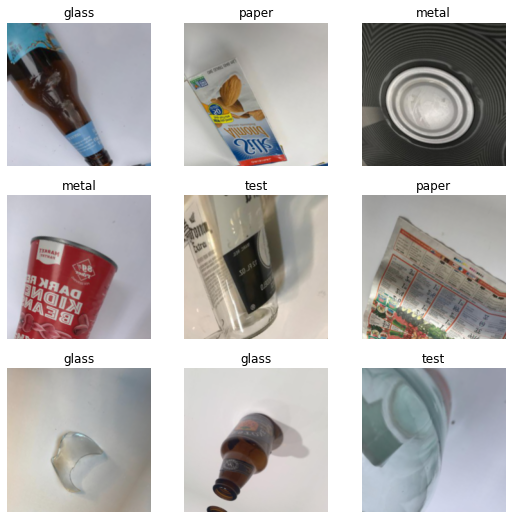

In [54]:
data.valid_ds.items[:3]

data.train.show_batch()



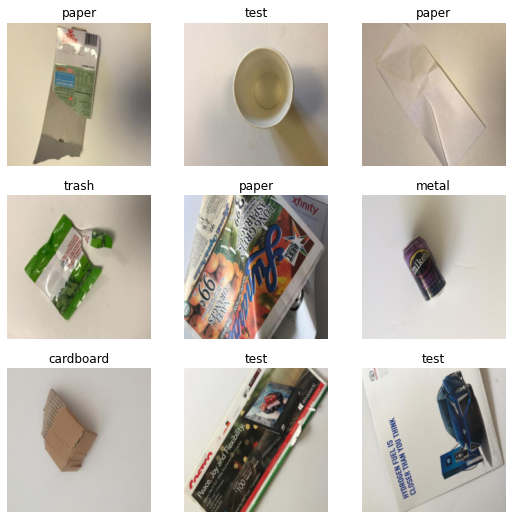

In [55]:
data.valid.show_batch()


In [56]:
data.vocab


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'test', 'trash']

In [57]:
learn = cnn_learner(data, resnet50, metrics=accuracy)
learn.fine_tune(20)
learn.export(fname=f'{BASE_DIR}/result-resnet34.pkl')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.297323,2.182213,0.503968,00:25


epoch,train_loss,valid_loss,accuracy,time
0,1.702640,1.733936,0.551587,00:28
1,1.513546,1.639260,0.571429,00:26
2,1.424108,1.609368,0.551587,00:26
3,1.292892,1.638101,0.563492,00:27
4,1.192396,1.685945,0.555556,00:26
5,1.110376,1.740327,0.547619,00:26
6,1.018920,1.360123,0.595238,00:27
7,0.909988,1.574493,0.571429,00:26
8,0.785839,1.488012,0.603175,00:26
9,0.727600,1.549205,0.567460,00:26


In [59]:
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *
from os import listdir
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from mlxtend.plotting import plot_confusion_matrix

def get_predictions(learn_object, TEST_FOLDER):
    return list(map(lambda x: (x, learn_object.predict(f"{TEST_FOLDER}/{x}")[0]), listdir(TEST_FOLDER)))

def show_predictions(learn_loaded, TEST_FOLDER):
    preds = get_predictions(learn_loaded, TEST_FOLDER)

    rows=5
    cols = 3
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

    for i in range(rows):
        for j in range(cols):        
            if img_count < len(preds):
                image=Image.open(f"{TEST_FOLDER}/{preds[img_count][0]}")
                axes[i, j].set_title(preds[img_count][1])
                axes[i, j].imshow(image)
                img_count+=1
    fig.show()

def print_results(classes, learn_loaded, DATASET_DIR, result_file):
    preds = []
    actuals = []
    for c in classes:
        predictions = get_predictions(learn_loaded, f"{DATASET_DIR}/{c}")
        preds.extend(predictions)
        actuals.extend(np.full((1,len(predictions)), c).ravel().tolist())
    pred_vals = list(map(lambda x : x[1], preds))
    print('Accuracy', accuracy_score(actuals, pred_vals))
    print('F1 score', f1_score(actuals, pred_vals, average='macro'))
    print(classification_report(y_pred=actuals, y_true=pred_vals))

    cm  = confusion_matrix(actuals, pred_vals)

    fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=classes)
    plt.show()
    fig.savefig(result_file) 
    plt.close(fig)

FileNotFoundError: ignored

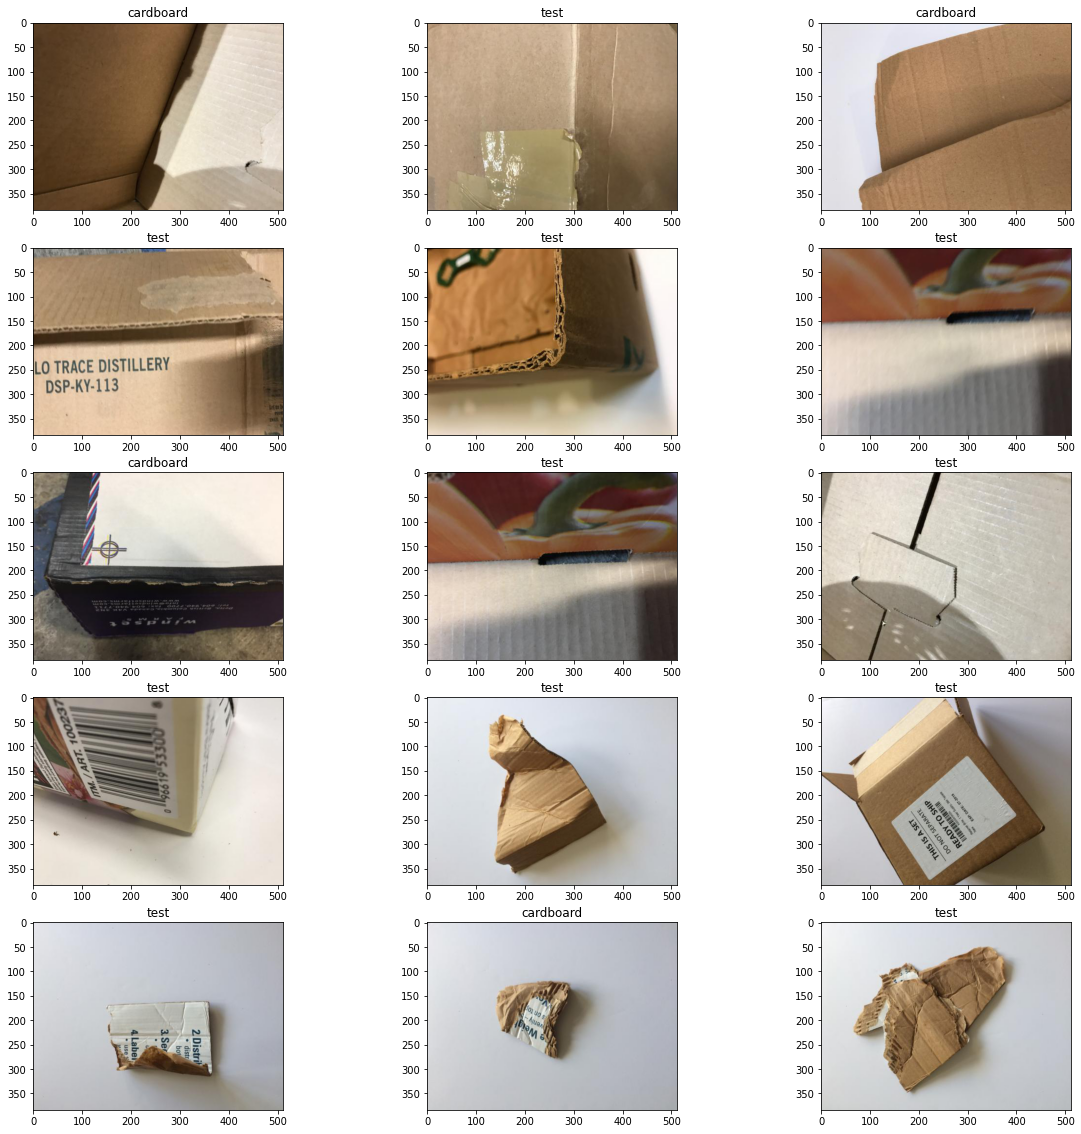

In [60]:
learn_loaded = load_learner(f'{BASE_DIR}/result-resnet34.pkl')
# show_predictions(learn_loaded, TEST_PHOTOS_DIR)                      
# print_results(data.vocab, learn_loaded, f"{DATASET_DIR}/test", 'glass397.jpg')

In [62]:
# print_results(data.vocab, learn_loaded, TEST_PHOTOS_DIR, 'glass397.jpg')


# print_results(classes, learn_loaded, DATASET_DIR, result_file)

FileNotFoundError: ignored